# ***ETS***

This notebook demonstrates the process of designing, training, and evaluating an SARIMA using the hourly energy load data.
We aim to forecast future energy load based on historical data.

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller

In [2]:
# Load the dataset
file_path = 'dataset.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset and summary statistics
data.head()

,Datetime,PJM_Load_MW
0,1998-12-31 01:00:00,29309.0
1,1998-12-31 02:00:00,28236.0
2,1998-12-31 03:00:00,27692.0
3,1998-12-31 04:00:00,27596.0
4,1998-12-31 05:00:00,27888.0


In [3]:
data.describe(include='all')

,Datetime,PJM_Load_MW
count,32896,32896.000000
unique,32896,NaN
top,1998-12-31 01:00:00,NaN
freq,1,NaN
mean,NaN,29766.427408
std,NaN,5849.769954
min,NaN,17461.000000
25%,NaN,25473.000000
50%,NaN,29655.000000
75%,NaN,33073.250000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32896 entries, 0 to 32895
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Datetime     32896 non-null  object 
 1   PJM_Load_MW  32896 non-null  float64
dtypes: float64(1), object(1)
memory usage: 514.1+ KB


### PreProcessing

In [5]:
# Drop rows with NaN values
data = data.dropna()

# Replace infinite values with zeros
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(0, inplace=True)  # Optional: fill remaining NaNs if any

In [ ]:
# Convert 'Datetime' to datetime type
data['Datetime'] = pd.to_datetime(data['Datetime'])

### Stationarity Test

In [6]:
# Function to perform the Augmented Dickey-Fuller test for stationarity
def check_stationarity(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] < 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary and needs differencing.")

# Perform the test
check_stationarity(data['PJM_Load_MW'])


ADF Statistic: -14.496714853893716
p-value: 6.024269615144993e-27
The series is stationary.


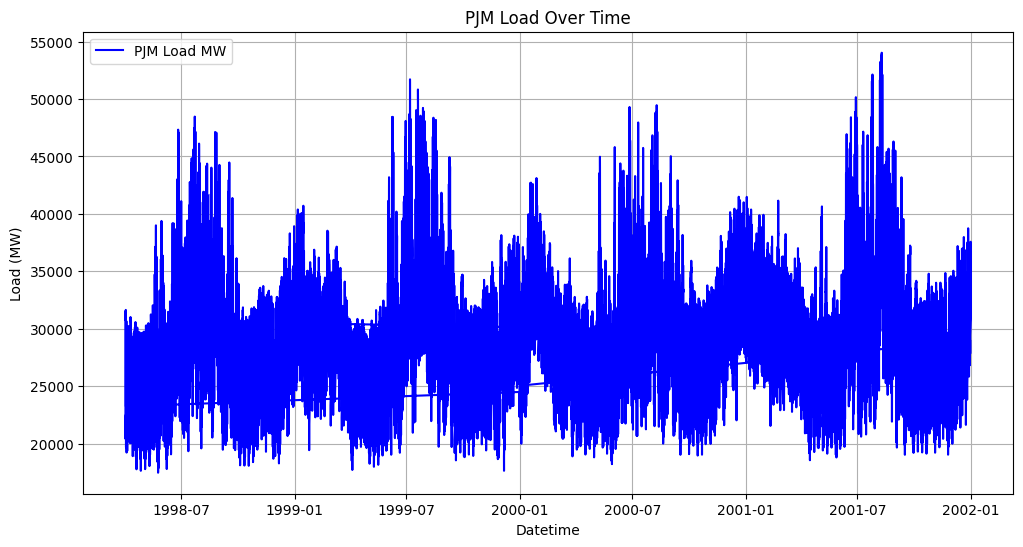

In [7]:
import matplotlib.pyplot as plt

# Plotting the time series data
plt.figure(figsize=(12, 6))
plt.plot(data['Datetime'], data['PJM_Load_MW'], label='PJM Load MW', color='blue')
plt.title('PJM Load Over Time')
plt.xlabel('Datetime')
plt.ylabel('Load (MW)')
plt.legend()
plt.grid(True)
plt.show()


### Differncing

In [ ]:
# Applying a logarithmic transformation
data['Log_PJM_Load_MW'] = np.log(data['PJM_Load_MW'])

# Differencing the log-transformed data
data['Diff_Log_PJM_Load_MW'] = data['Log_PJM_Load_MW'].diff().dropna()

# Check stationarity of the differenced log data
check_stationarity(data['Diff_Log_PJM_Load_MW'].dropna())


In [ ]:
import matplotlib.pyplot as plt

# Plotting the time series data
plt.figure(figsize=(12, 6))
plt.plot(data['Datetime'], data['Diff_Log_PJM_Load_MW'], label='PJM Load MW', color='blue')
plt.title('PJM Load Over Time')
plt.xlabel('Datetime')
plt.ylabel('Load (MW)')
plt.legend()
plt.grid(True)
plt.show()

### Model Training

In [8]:
# Fit the Holt-Winters model
# Since data has both trend and seasonality, we use the 'additive' option for both
# The seasonal_periods argument will be assumed based on common sense about the data
# Here we'll assume daily seasonality as a start, given hourly data, so 24 hours
model = ExponentialSmoothing(data['PJM_Load_MW'].dropna(), trend='add', seasonal='add', seasonal_periods=24)
fitted_model = model.fit()

# Display model summary
fitted_model.summary()


c:\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Dep. Variable:,PJM_Load_MW,No. Observations:,32896
Model:,ExponentialSmoothing,SSE,28919865626.504
Optimized:,True,AIC,450293.296
Trend:,Additive,BIC,450528.527
Seasonal:,Additive,AICC,450293.353
Seasonal Periods:,24,Date:,"Sat, 11 May 2024"
Box-Cox:,False,Time:,21:14:05
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7828759,alpha,True
smoothing_trend,0.0001676,beta,True


### Evaluation Metrics

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Compute predictions
predictions = fitted_model.fittedvalues
accuracy_threshold=5

# Calculate errors
mae = mean_absolute_error(data['PJM_Load_MW'].dropna(), predictions)
mse = mean_squared_error(data['PJM_Load_MW'].dropna(), predictions)
rmse = mse ** 0.5

# Calculate accuracy
accurate_predictions = np.sum(np.abs((data['PJM_Load_MW'].dropna() - predictions) / data['PJM_Load_MW'].dropna()) <= accuracy_threshold)
total_predictions = len(data['PJM_Load_MW'].dropna())
accuracy = (accurate_predictions / total_predictions)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Accuracy: {accuracy}')

Mean Absolute Error: 618.7360814314022
Mean Squared Error: 879130.1564477284
Root Mean Squared Error: 937.6194091675621
Accuracy: 100.0


### Saving Model

In [13]:
import pickle

# Assume 'sarima_model' is your trained SARIMA model
model_filename = 'ETS.pkl'  # specify the path and file name

# Save the model to disk
with open(model_filename, 'wb') as file:
    pickle.dump(fitted_model, file)

print("Model saved successfully at:", model_filename)

Model saved successfully at: ETS.pkl


### Forcasting

In [14]:
import pickle

# Specify the path where your model is saved
model_filename = 'ETS.pkl'  # replace with the actual path to your model file

# Load the model from disk
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)
    
# Make predictions using the loaded modelfor next 12 steps
forecast = loaded_model.forecast(steps=12)
print(forecast)

32896    27256.717188
32897    26991.739753
32898    26647.443116
32899    26484.981158
32900    26802.197268
32901    28186.567167
32902    31072.556167
32903    33253.411798
32904    33934.734685
32905    34088.419459
32906    34099.730326
32907    33907.542720
dtype: float64
